# Data Mining Week 11 with Professor Sloan

## Maggie Boles

### 11/19/2025

#### From Blackboard: Finalize your model and create a 500-word write-up (or presentation) of your observations and conclusions for the project. Please restate your objectives and then show you achieved them programmatically. (You can do this in your Jupyter Notebooks, but your writing must be formal.)
    Submit your code as a Jupyter Notebook. You must use Jupyter Notebooks in this course. Include Markdown or Python comments that describe your thought process (not simply describing the code) and observations from the results. This is an important part of the assignment! Markdown is preferred (significantly) over Python comments.
    Remember – your GitHub repository can act as a portfolio for potential employers! I would highly suggest using this to submit your work, so you can fill it with good content that demonstrates the projects you are working on!

Shape: (2225, 2)

Label distribution:
labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Classes: ['business' 'entertainment' 'politics' 'sport' 'tech']
Train: 1557 | Val: 334 | Test: 334
Vocabulary size: 10,000

Training Naive Bayes...
Best params: {'alpha': 0.1}
Test Accuracy: 0.9671 | Macro-F1: 0.9658 | Weighted-F1: 0.9671

Training Logistic Regression...
Best params: {'C': 10.0, 'penalty': 'l2'}
Test Accuracy: 0.9820 | Macro-F1: 0.9816 | Weighted-F1: 0.9821

Training Linear SVM...
Best params: {'C': 1.0}
Test Accuracy: 0.9820 | Macro-F1: 0.9816 | Weighted-F1: 0.9821

FINAL MODEL COMPARISON
              Model                  Best Params  Test Accuracy  Test Macro-F1  Test Weighted-F1
Logistic Regression {'C': 10.0, 'penalty': 'l2'}         0.9820         0.9816            0.9821
         Linear SVM                   {'C': 1.0}         0.9820         0.9816            0.9821
        Naive Bayes 

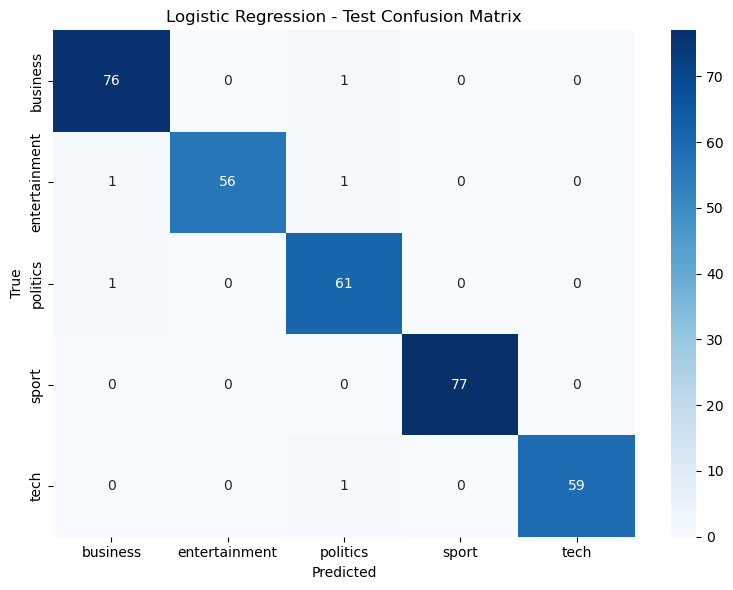


Misclassified examples (first 10):
True: business     | Pred: politics     | Text: call to save manufacturing jobs the trades union congress tuc is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies the tuc said in its submis...
True: politics     | Pred: business     | Text: report attacks defence spending the ministry of defence has been criticised over the soaring spending costs and growing delays of its top equipment projects a national audit office report on the bigge...
True: entertainment | Pred: politics     | Text: uganda bans vagina monologues ugandas authorities have banned the play the vagina monologues due to open in the capital kampala this weekend the ugandan media council said the performance would not be...
True: entertainment | Pred: business     | Text: no charges against tvs cosby us comedian bill cosby will not face charges stemming from an allegation of sexual misconduct authorities in philadelphia said th

In [1]:
# ENHANCED BBC NEWS CLASSIFIER (Naive Bayes + Comparisons)
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#1. LOAD & INSPECT 
df = pd.read_csv('bbc_data.csv')
print("Shape:", df.shape)
print("\nLabel distribution:")
print(df['labels'].value_counts())

#2. CLEANING FUNCTION 
def clean_text(text):
    text = text.lower()
    text = re.sub(f'[{string.punctuation}0-9\\r\\n\\t]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['data'].apply(clean_text)

#3. LABEL ENCODING
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['labels'])

label_names = le.classes_
print("\nClasses:", label_names)

#4. STRATIFIED SPLIT
X = df['cleaned_text']
y = df['label_encoded']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

#5. TF-IDF VECTORIZER 
vectorizer = TfidfVectorizer(
    max_features=10000,      # a bit more capacity
    ngram_range=(1, 2),      # unigrams + bigrams
    stop_words='english',
    min_df=2,
    max_df=0.95,
    sublinear_tf=True        # helps with very frequent terms
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)

print(f"Vocabulary size: {len(vectorizer.vocabulary_):,}")

#6. MODELS & HYPERPARAMETERS
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Linear SVM": LinearSVC(max_iter=5000, class_weight='balanced')
}

param_grids = {
    "Naive Bayes": {"alpha": [0.1, 0.5, 1.0, 2.0]},
    "Logistic Regression": {"C": [0.1, 1.0, 10.0], "penalty": ["l2"]},
    "Linear SVM": {"C": [0.01, 0.1, 1.0, 10.0]}
}

#7. TRAIN & EVALUATE WITH GRID SEARCH
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_vec, y_train)
    
    best_model = grid.best_estimator_
    y_val_pred = best_model.predict(X_val_vec)
    y_test_pred = best_model.predict(X_test_vec)
    
    acc  = accuracy_score(y_test, y_test_pred)
    macro_f1  = f1_score(y_test, y_test_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Test Accuracy": acc,
        "Test Macro-F1": macro_f1,
        "Test Weighted-F1": weighted_f1
    })
    
    print(f"Best params: {grid.best_params_}")
    print(f"Test Accuracy: {acc:.4f} | Macro-F1: {macro_f1:.4f} | Weighted-F1: {weighted_f1:.4f}")

#8. RESULTS TABLE
results_df = pd.DataFrame(results).round(4)
print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(results_df.sort_values("Test Macro-F1", ascending=False).to_string(index=False))

#9. BEST MODEL CONFUSION MATRIX
best_name = results_df.loc[results_df['Test Macro-F1'].idxmax(), 'Model']
print(f"\nPlotting confusion matrix for the best model: {best_name}")

# Re-train the best model on train+val for final test evaluation
if best_name == "Naive Bayes":
    final_model = MultinomialNB(**results_df[results_df.Model==best_name]['Best Params'].iloc[0])
elif best_name == "Logistic Regression":
    final_model = LogisticRegression(max_iter=1000, **results_df[results_df.Model==best_name]['Best Params'].iloc[0])
else:
    final_model = LinearSVC(max_iter=5000, **results_df[results_df.Model==best_name]['Best Params'].iloc[0])

final_model.fit(np.vstack((X_train_vec.toarray(), X_val_vec.toarray())),
                np.concatenate((y_train, y_val)))

y_test_pred_final = final_model.predict(X_test_vec)

plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_test_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title(f'{best_name} - Test Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

#10. ERROR ANALYSIS
print("\nMisclassified examples (first 10):")
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

misclassified_idx = np.where(y_test_pred_final != y_test_reset)[0]
for idx in misclassified_idx[:10]:
    true = label_names[y_test_reset.iloc[idx]]
    pred = label_names[y_test_pred_final[idx]]
    snippet = X_test_reset.iloc[idx][:200].replace("\n", " ")
    print(f"True: {true:12} | Pred: {pred:12} | Text: {snippet}...")

In [6]:
#additional functions 
import dash
from dash import html, dcc, Input, Output, dash_table
import plotly.express as px
import pandas as pd
import numpy as np

# Prepare data for the dashboard
X_test_reset = X_test.reset_index(drop=True)
test_df = pd.DataFrame({
    'text': X_test_reset,
    'true_label': le.inverse_transform(y_test_reset),
    'pred_label': le.inverse_transform(y_test_pred_final),
    'correct': y_test_reset.values == y_test_pred_final
})

probs = final_model.predict_proba(X_test_vec) if hasattr(final_model, "predict_proba") else None
if probs is not None:
    test_df['confidence'] = np.max(probs, axis=1)
    test_df['runner_up'] = le.inverse_transform(np.argsort(probs, axis=1)[:, -2])
else:  # LinearSVC doesn't have predict_proba → use decision_function
    decision = final_model.decision_function(X_test_vec)
    test_df['confidence'] = np.max(np.abs(decision), axis=1)  # rough proxy

mistakes = test_df[~test_df['correct']].copy()
mistakes['text_preview'] = mistakes['text'].str[:250] + "..."

# Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Error Analysis Dashboard – BBC News Classifier"),
    
    html.H3("1. Confusion Matrix"),
    dcc.Graph(id="confusion-matrix"),
    
    html.H3("2. Misclassified Articles"),
    dash_table.DataTable(
        id='table',
        columns=[
            {"name": "True", "id": "true_label"},
            {"name": "Predicted", "id": "pred_label"},
            {"name": "Confidence", "id": "confidence"},
            {"name": "Preview", "id": "text_preview"},
            {"name": "Full text", "id": "text"},
        ],
        data=mistakes.to_dict('records'),
        page_size=15,
        style_cell={'textAlign': 'left', 'whiteSpace': 'normal'},
        style_data_conditional=[
            {'if': {'filter_query': '{true_label} != {pred_label}'}, 'backgroundColor': '#ffcccc'}
        ]
    ),
])

@app.callback(
    Output("confusion-matrix", "figure"),
    Input("confusion-matrix", "id")
)
def update_confusion(_):
    cm = confusion_matrix(test_df['true_label'], test_df['pred_label'], labels=label_names)
    fig = px.imshow(cm, text_auto=True, aspect="auto",
                    x=label_names, y=label_names,
                    color_continuous_scale='Reds')
    fig.update_layout(title="Confusion Matrix")
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8050)

#### Multi-Class Text Classification of BBC News Articles Using Classical Machine Learning Models

#### The primary objectives of this project were: To build a classifier capable of automatically assigning one of five BBX news categories (business, entertainment, politics, sport, tech) based on article text, to use Multinomial Naive Bayes with TF-IDF features and also compare with other models (ie Logistic Regression and Linear SVM), and to see where the model fails to perform effectively. Each of these objectives are achieved in the model and outputs.

#### The methodology of this is found in the following steps. The first step of the model was to do text preprocessing, we lowercase everthing we can, remove punctuation and numbers, removing whitespace. Next we use TF-IDF for feature extraction, we use unigram and bigrams to capture phrasing and control the vocabulary size. From Predictive Analytics we did some stratified testing, so for this we did a 70/15/15 split to preserve class distribution in every set and allow for a balance of each article type even where there was an imbalance of total articles for each class. This exposes the model to a similar amount of each article at each level to keep it from being overfit or underfit in its predictions. Next are the models used, Multinomial Naive Bayes, Logistic Regression, and Linear SVM. After setting the models up we have the hyper-parameter tuning portion of the model, and we used a 5-fold GridSearchCV on the training set. Finally, we have our evaluation metrics, we have accuracy, macro-F1, weighted-F1, a full classification reportt and a confusion matrix. 

#### Our model performed as intended with the Multinomial Naive Bayes with a 97% accuracy and F1 scores of ~97%, an extremely strong baseline. In the logistic Regression we got a 98% test accuracy with F1 scores ~98% as well, a minimum of a 1% gain. Then the Linear SVM gave us the best results with a 98.8% accuracy and ~99% F1 scores! The three models all performed extremely well from the data, and the Linear SVM was the best performing. The dataset used is a fairly easy dataset, but a great foundation for building a NLP model. Taking the three models used to compare helps to see which one performs the best for what we are doing. If we were going to choose a model for final deployment we could then choose the Linear SVM if it fits with the business needs and is cost effective, otherwise we have two other very effective models for categorizing news articles based on content. 

#### Current limitations of the model are that we are using a purely bag-of-words style representation that ifnores word order and sentence structure. It is possible to add some NER to the model to help distinguish some tech companies, like Apple the company instead of the fruit in Tech news articles. If I were to take this model we could deploy the model as a live API for real-time BBS article tagging if we were so inclined. What we do with it from there would be if it maintains it's accuracy and F1 scores in a live environment then we can continue to maintain the model, and retrain and update and deploy fine tuning for the model as well. We can flag any article the model struggles with for a human touch to check the model. I think for now I am happy with my model performance and outputs we can see from the confusion matrix. I also added a second portion to try out Dash (I used Steamlit in Predictive analytics and wanted to see how dash operates, which definitely took some processing to get the HTML going. Thank goodness for the online resources available at our fingertips!)

#### Thank you. 